## LSST Solar System Processing

## Linking of Simulated dataset with HelioLinC3D

### Algorithm: 

* Similar to HelioLinC (Holman et al. 2018) we transform topocentric observations to heliocentric states assuming a distance and radial velocity.
* The resulting 3D positions are collected into tracklets. Tracklets contain at least two observations and can, thus, be used to create velocity vectors.
* A tracklet + velocity vector is called an "arrow". 
* Arrows are propagated to a common epoch using spiceypy's 2body propagator, and then clustered using dbscan.
* We calculate a mean state and variance for each cluster (trimmed mean), which is our best guess for the underlying orbit (IOD)
* We can filter all clusters based on their variance

### Implementation:
S. Eggl 20210218
    

In [122]:
import numpy as np

In [1767]:
from astroquery.jplhorizons import Horizons

In [2050]:
import spiceypy as sp

In [1780]:
tstart='JD2459000'
tstop='JD2460000'


In [1786]:
observer_sun = Horizons(id='Sun', location='I11', id_type='majorbody',
              epochs = {'start':tstart, 'stop':tstop,
              'step':'11h'})

In [1788]:
barycenter_sun = Horizons(id='Sun', location='@0', id_type='majorbody',
              epochs = {'start':tstart, 'stop':tstop,
              'step':'11h'})

In [1787]:
observer_sun.vectors()

targetname,datetime_jd,datetime_str,x,y,z,vx,vy,vz,lighttime,range,range_rate
---,d,---,AU,AU,AU,AU / d,AU / d,AU / d,d,AU,AU / d
str8,float64,str30,float64,float64,float64,float64,float64,float64,float64,float64,float64
Sun (10),2459000.0,A.D. 2020-May-30 12:00:00.0000,0.3590096964824342,0.9481309371711674,-2.314726948975703e-05,-0.01582210762406129,0.005937821364008411,9.223419170466912e-05,0.005855362326202204,1.013824559144866,-4.977198049594843e-05
Sun (10),2459000.458333333,A.D. 2020-May-30 23:00:00.0000,0.3518247254733414,0.9509098468037757,-1.823331090733347e-05,-0.01578672581152066,0.006230392250958992,-8.850132158375584e-05,0.005855846353918275,1.013908365945969,0.0003653017296609674
Sun (10),2459000.916666667,A.D. 2020-May-31 10:00:00.0000,0.3444806080702975,0.9536718568978375,-3.034526168779727e-05,-0.01602346797024079,0.005722139492532492,7.84298496300044e-05,0.005856264237121951,1.013980720179771,-6.186801507898552e-05
Sun (10),2459001.375,A.D. 2020-May-31 21:00:00.0000,0.3372395252194582,0.956306463395725,-1.217834524386746e-05,-0.01577565280578552,0.005925453506294197,-6.426497090984332e-05,0.005856536632406655,1.014027883961283,0.0003415848937583125
Sun (10),2459001.833333333,A.D. 2020-Jun-01 08:00:00.0000,0.3298787441267578,0.9589807152262186,-3.57274498885653e-05,-0.01618994732234557,0.005551169880978747,4.47670259082276e-05,0.005857138770473754,1.01413214093573,-1.701575769626102e-05
Sun (10),2459002.291666667,A.D. 2020-Jun-01 19:00:00.0000,0.3225690031215265,0.9614813183145245,-8.92484911253887e-06,-0.01580326782475194,0.005582591909319268,-2.388496865576922e-05,0.005857232988503428,1.014148454281869,0.0002661481091073895
Sun (10),2459002.75,A.D. 2020-Jun-02 06:00:00.0000,0.3152042270613103,0.964053736122659,-3.800556914992029e-05,-0.01630132953999439,0.005405363236358907,-2.847501036549376e-07,0.005857962536574051,1.014274771614575,7.178790032647542e-05
Sun (10),2459003.208333333,A.D. 2020-Jun-02 17:00:00.0000,0.3078207275440147,0.9664356908247681,-9.376364054252208e-06,-0.01588392511950008,0.005225519025150576,2.242063971280884e-05,0.005857957504462438,1.014273900331459,0.0001584645845403238


In [1791]:
barycenter_sun.vectors()

targetname,datetime_jd,datetime_str,x,y,z,vx,vy,vz,lighttime,range,range_rate
---,d,---,AU,AU,AU,AU / d,AU / d,AU / d,d,AU,AU / d
str8,float64,str30,float64,float64,float64,float64,float64,float64,float64,float64,float64
Sun (10),2459000.0,A.D. 2020-May-30 12:00:00.0000,-0.005036698976971318,0.007028539778863855,5.77566602895832e-05,-8.112734937916378e-06,-3.561853947445847e-06,2.328574386317633e-07,4.994138618980652e-05,0.008647082967076428,1.831857140079116e-06
Sun (10),2459000.458333333,A.D. 2020-May-30 23:00:00.0000,-0.005040417041162431,0.007026905905598763,5.786338702461194e-05,-8.111542518443507e-06,-3.56777609838345e-06,2.328590402151962e-07,4.994623331157585e-05,0.008647922220194709,1.830336098571116e-06
Sun (10),2459000.916666667,A.D. 2020-May-31 10:00:00.0000,-0.00504413455517555,0.007025269316314605,5.797011424252174e-05,-8.110334143634882e-06,-3.573705617918981e-06,2.328595470349935e-07,4.995107638968614e-05,0.008648760773175126,1.828802020796197e-06
Sun (10),2459001.375,A.D. 2020-May-31 21:00:00.0000,-0.005047851511674429,0.00702363000770121,5.80768414433464e-05,-8.109109713148693e-06,-3.579642214100059e-06,2.328589670121786e-07,4.995591538984982e-05,0.008649598620080978,1.827255073857071e-06
Sun (10),2459001.833333333,A.D. 2020-Jun-01 08:00:00.0000,-0.005051567903279108,0.007021987976581017,5.818356813083834e-05,-8.107869136447613e-06,-3.585585600254367e-06,2.328573084512837e-07,4.996075027822299e-05,0.008650435755052371,1.825695425750641e-06
Sun (10),2459002.291666667,A.D. 2020-Jun-01 19:00:00.0000,-0.005055283722570234,0.007020343219906624,5.829029381263154e-05,-8.10661233206097e-06,-3.591535495077481e-06,2.328545799665206e-07,4.996558102140707e-05,0.008651272172306525,1.824123244894773e-06
Sun (10),2459002.75,A.D. 2020-Jun-02 06:00:00.0000,-0.00505899896209306,0.007018695734758326,5.839701800036573e-05,-8.105339226892895e-06,-3.597491622675263e-06,2.328507904158853e-07,4.997040758644946e-05,0.008652107866137864,1.822538699717096e-06
Sun (10),2459003.208333333,A.D. 2020-Jun-02 17:00:00.0000,-0.005062713614361132,0.007017045518341626,5.850374020978636e-05,-8.1040497555752e-06,-3.603453712567669e-06,2.328459488425316e-07,4.997522994084296e-05,0.008652942830917953,1.820941958299585e-06


In [123]:
min(4,3)

3

In [124]:
# HelioLinC3D Solar System Processing functions for LSST
import heliolinc2 as hl

In [125]:
# Did I Find It Analysis tool (Moeyens et al.)
import difi

In [126]:
from difi import __version__
print("difi version: {}".format(__version__))

difi version: 1.1


In [127]:
# Demo relevant python modules
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [128]:
# Joblib prallelization
import joblib
from joblib.externals.loky import set_loky_pickler
from joblib import parallel_backend
from joblib import wrap_non_picklable_objects
from joblib import Parallel, delayed

In [129]:
# Progress bar for joblib processes
import contextlib
from tqdm import tqdm

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback:
        def __init__(self, time, index, parallel):
            self.index = index
            self.parallel = parallel

        def __call__(self, index):
            tqdm_object.update()
            if self.parallel._original_iterator is not None:
                self.parallel.dispatch_next()

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()   

In [130]:
dfin0=pd.read_csv("PG008_initial_final.txt",'\s+',skiprows=1,names=['time','RA','DEC']).dropna()
dfin1=pd.read_csv("PG021_initial_final.txt",'\s+',skiprows=1,names=['time','RA','DEC']).dropna()
dfin2=pd.read_csv("PG023_initial_final.txt",'\s+',skiprows=1,names=['time','RA','DEC']).dropna()

In [139]:
trailin0=pd.read_csv("PG008_central_time_coord_vel.txt",'\s+',skiprows=1,names=['time','RA_center','DEC_center','RA_vel','DEC_vel'])
trailin1=pd.read_csv("PG021_central_time_coord_vel.txt",'\s+',skiprows=1,names=['time','RA_center','DEC_center','RA_vel','DEC_vel'])
trailin2=pd.read_csv("PG023_central_time_coord_vel.txt",'\s+',skiprows=1,names=['time','RA_center','DEC_center','RA_vel','DEC_vel'])

In [136]:
trailin1

,time,RA_center,DEC_center,RA_vel,DEC_vel
0,59141.092975,350.578029,-5.327897,-0.015506,-0.005643
1,59141.092975,350.382756,-5.245927,-0.028803,-0.002545
2,59141.092975,350.727422,-5.326696,-0.015541,-0.006609
3,59141.092975,350.855068,-5.296072,-0.013863,-0.005894
4,59141.092975,351.097480,-5.204408,-0.015887,-0.005806
...,...,...,...,...,...
100,59141.092975,351.486135,-6.030596,-0.013455,-0.004919
101,59141.092975,351.541850,-6.093940,-0.014527,-0.006184
102,59141.092975,350.825077,-6.298489,-0.015509,-0.005657
103,59141.092975,350.893131,-6.219433,-0.013786,-0.005027


## SIMULATED OBSERVATIONS 


### Select observations from LSST Survey Simulation Dataset

Cornwall et al. 2020, 5deg x 5deg, 14 nights 

In [8]:
data_dir='../baseline_fbs_v1p7p1/S1_00/'
# S3M Main Belt Asteroids (MBA)
fnobservations0='visit-0000000.h5'
fnobservations1='visit-0010000.h5'
# S3M Near-Earth Objects (NEO)

In [9]:
#data_dir='../baseline_fbs_v1p7p1/centaurs/'
# S3M Main Belt Asteroids (MBA)
#fnobservations1='centaurs_00001.h5'
# S3M Near-Earth Objects (NEO)
#fnobservations0='centaurs_10001.h5'

In [10]:
#dfin0= pd.read_csv(os.path.join(data_dir, fnobservations0),nrows=240000, sep=',').dropna()
#dfin1= pd.read_csv(os.path.join(data_dir, fnobservations1),nrows=240000, sep=',').dropna()

In [11]:
dfin0= pd.read_hdf(os.path.join(data_dir, fnobservations0)).dropna()
dfin1= pd.read_hdf(os.path.join(data_dir, fnobservations1)).dropna()

In [12]:
dfin0['class']='MBA'
dfin1['class']='MBA'

In [13]:
ffalsename='false_detections_fbs-v1_7_1-'
fformat='.csv'

ffalse=[]
for l in range(0,12500,500):
    ffalse.append(ffalsename+str(l).zfill(7)+fformat)


In [14]:
ffalse

['false_detections_fbs-v1_7_1-0000000.csv',
 'false_detections_fbs-v1_7_1-0000500.csv',
 'false_detections_fbs-v1_7_1-0001000.csv',
 'false_detections_fbs-v1_7_1-0001500.csv',
 'false_detections_fbs-v1_7_1-0002000.csv',
 'false_detections_fbs-v1_7_1-0002500.csv',
 'false_detections_fbs-v1_7_1-0003000.csv',
 'false_detections_fbs-v1_7_1-0003500.csv',
 'false_detections_fbs-v1_7_1-0004000.csv',
 'false_detections_fbs-v1_7_1-0004500.csv',
 'false_detections_fbs-v1_7_1-0005000.csv',
 'false_detections_fbs-v1_7_1-0005500.csv',
 'false_detections_fbs-v1_7_1-0006000.csv',
 'false_detections_fbs-v1_7_1-0006500.csv',
 'false_detections_fbs-v1_7_1-0007000.csv',
 'false_detections_fbs-v1_7_1-0007500.csv',
 'false_detections_fbs-v1_7_1-0008000.csv',
 'false_detections_fbs-v1_7_1-0008500.csv',
 'false_detections_fbs-v1_7_1-0009000.csv',
 'false_detections_fbs-v1_7_1-0009500.csv',
 'false_detections_fbs-v1_7_1-0010000.csv',
 'false_detections_fbs-v1_7_1-0010500.csv',
 'false_detections_fbs-v1_7_1-00

In [15]:
# false detections
# ffalse=['false_detections_fbs-v1_7_1-0000000.csv',
#        'false_detections_fbs-v1_7_1-0000500.csv',
#        'false_detections_fbs-v1_7_1-0001500.csv',
#        'false_detections_fbs-v1_7_1-0002000.csv',
#        'false_detections_fbs-v1_7_1-0002500.csv'
#        'false_detections_fbs-v1_7_1-0003000.csv'
        
#        ]
data_dir2='../baseline_fbs_v1p7p1/data_baseline_v1p7p1/'
#fnoise='false_detections_fbs-v1_7_1-0000000.csv'

In [15]:
#dfinf0=pd.read_csv('../baseline_fbs_v1p7p1/data_baseline_v1p7p1/false_detections_fbs-v1_7_1-0000000.csv')

In [65]:
dfinf=[]

for f in ffalse:
    dfinf.append(pd.read_csv(os.path.join(data_dir2, f)))
#dfinf1= pd.read_csv(os.path.join(data_dir2, ffalse1))

In [66]:
dfinf0=pd.concat(dfinf)

In [67]:
dfinf0['FieldID']=dfinf0['observationId']
dfinf0['class']='False_Detections'

In [68]:
dfinf0.drop(columns=['observationId','AstRASigma(mas)','AstDecSigma(mas)','PhotometricSigma(mag)'],inplace=True)

In [20]:
#!ls ../baseline_fbs_v1p7p1/data_baseline_v1p7p1/false_detections_fbs-v1_7_1-0000000.csv

In [8]:
# combine datasets
# dfin=pd.concat([dfin0,dfin1,dfinf0])
dfin=pd.concat([dfin0,dfin1,dfin2])
# re-index new dataset 
dfin.reset_index(drop=True,inplace=True);
# preserve observation identifier as string
dfin['obsName']=dfin.index.astype(str);

In [9]:
dfin

,time,RA,DEC,obsName
0,58724.211918,351.129399,-4.943011,0
1,58724.387113,351.126630,-4.944023,1
2,58724.211918,351.365065,-4.922767,2
3,58724.387113,351.362205,-4.923985,3
4,58724.211918,351.493602,-4.912272,4
...,...,...,...,...
533,59141.170607,350.823873,-6.298928,533
534,59141.015429,350.894200,-6.219044,534
535,59141.170607,350.892061,-6.219824,535
536,59141.015429,351.552535,-6.290649,536


In [10]:
# help(hl)

Select subset RA [310, 315] deg, Dec [-10, -5] deg, 16 nights 

In [11]:
# dfin_sel = hl.selectObservationSubset(dfin, RAmin=315, RAmax=320, DECmin=-10, DECmax=-5,
#                             timemin=dfin['FieldMJD'].min(),timemax=dfin['FieldMJD'].min()+16,
#                             RAName='AstRA(deg)',DECName='AstDec(deg)',timeName='FieldMJD')

In [12]:
# dfin_sel

In [13]:
# dfin_sel.FieldID.max()

In [14]:
dfin

,time,RA,DEC,obsName
0,58724.211918,351.129399,-4.943011,0
1,58724.387113,351.126630,-4.944023,1
2,58724.211918,351.365065,-4.922767,2
3,58724.387113,351.362205,-4.923985,3
4,58724.211918,351.493602,-4.912272,4
...,...,...,...,...
533,59141.170607,350.823873,-6.298928,533
534,59141.015429,350.894200,-6.219044,534
535,59141.170607,350.892061,-6.219824,535
536,59141.015429,351.552535,-6.290649,536


In [15]:
# convert observations to HelioLinC ingestible format
import warnings
warnings.filterwarnings('ignore')
dfobs=hl.obs2heliolinc(dfin,uniqueObsId=True, uniqueObsIdName="obsName", 
                  timeName="time", raName="RA", 
                  decName="DEC", observerLocation='807')

In [16]:
dfobs

,index,time,RA,DEC,obsId,obsName,night
0,0,58724.211918,351.129399,-4.943011,0,0,0
1,1,58724.387113,351.126630,-4.944023,1,1,0
2,2,58724.211918,351.365065,-4.922767,2,2,0
3,3,58724.387113,351.362205,-4.923985,3,3,0
4,4,58724.211918,351.493602,-4.912272,4,4,0
...,...,...,...,...,...,...,...
533,533,59141.170607,350.823873,-6.298928,533,533,417
534,534,59141.015429,350.894200,-6.219044,534,534,417
535,535,59141.170607,350.892061,-6.219824,535,535,417
536,536,59141.015429,351.552535,-6.290649,536,536,417


### Analyze LSST Field

In [17]:
# hl.plot.plotField(dfin_sel,objName='ObjID',raName='AstRA(deg)',decName='AstDec(deg)')

### Since we are looking at a fraction of the sky, how many nights do we actually observe?

In [18]:
df_grouped_by_night=dfobs.groupby('night')

In [19]:
len(df_grouped_by_night.groups)

3

In [20]:
df_grouped_by_night.groups.keys()

dict_keys([0, 29, 417])

## Run HelioLinC3D

### Choose HelioLinC3D clustering parameters

In [1926]:
# Clustering radius for heliocentric positions projected from observations [au]
cr_obs=0.02
#cr_obs=0.5
# Clustering radius for propagated arrows [au]
cr_arrows=0.1

# max temporal separation for tracklet observations (days)
ct_max=20/24
# min temporal separation for tracklet observations, e.g. exposure time (days)
ct_min=25/86400 
# Minimum number of arrows to be clustered ('DBSCAN only')
min_samples=3

### Choose heliocentric distance and velocity grid

In [1927]:
# define range of heliocentric distances
#rall=np.arange(1.8,3.3,0.1)
#rall=np.arange(2,3.4,0.1)
rall=np.arange(2,3,0.01)
# define range of heliocentric radial velocities
drdtall=np.arange(-0.01,0.0151,0.001)
np.append(drdtall,0.0)

# Iterator for joblib based paralellization
rrdot=np.array(np.meshgrid(rall,drdtall)).T.reshape(-1,2)

# How many configuraitons do we have to run?
print(len(rrdot))

2600


In [1928]:
dfobs

,time,RA,DEC,RA_vel,DEC_vel,night,obsId
0,59846.000000,151.96078,18.61273,62.86641,-18.2245,0,0
6,59846.000000,152.96078,19.61273,62.86641,-18.2245,0,6
1,59846.083333,151.99769,18.60267,62.99025,-18.1377,0,1
7,59846.083333,154.99769,18.40267,62.99025,-18.1377,0,7
2,59847.000000,152.39944,18.49240,62.76400,-18.2503,1,2
8,59847.000000,151.39944,18.49240,62.76400,-18.2503,1,8
3,59847.083333,152.43626,18.48232,62.88522,-18.1632,1,3
9,59847.083333,151.43626,17.48232,62.88522,-18.1632,1,9
4,59850.000000,153.70890,18.13042,62.44117,-18.3063,4,4
10,59850.000000,154.70890,19.13042,62.44117,-18.3063,4,10


In [2426]:
import importlib
importlib.reload(hl)
import heliolinc2 as hl

In [2427]:
%load_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2428]:
%autoreload 2

In [2429]:
dftrails=pd.DataFrame()

In [2430]:
dftrails=pd.concat([trailin0,trailin1,trailin2]).reset_index(drop=True)

In [2431]:
hl.GM

0.0002959122082326087

In [2432]:
t=2459846.500000000

In [2433]:
ceres_good = np.array([[ 2459846.500000000,   151.96078,  18.61273, 62.86641,  -18.2245],
                       [2459846.583333333,     151.99769,  18.60267, 62.99025,  -18.1377], 
                       [2459847.500000000,    152.39944,  18.49240, 62.76400, -18.2503],
                       [2459847.583333333,     152.43626,  18.48232, 62.88522, -18.1632],
                       [2459850.500000000,  153.70890,  18.13042, 62.44117,  -18.3063], 
                       [2459850.583333333,     153.74546,  18.12031, 62.55443,  -18.2182]])


ceres_rnd = np.array([[ 2459846.500000000,   152.96078,  19.61273, 62.86641,  -18.2245],
                       [2459846.583333333,     154.99769,  18.40267, 62.99025,  -18.1377], 
                       [2459847.500000000,    151.39944,  18.49240, 62.76400, -18.2503],
                       [2459847.583333333,     151.43626,  17.48232, 62.88522, -18.1632],
                       [2459850.500000000,  154.70890,  19.13042, 62.44117,  -18.3063], 
                       [2459850.583333333,     155.74546,  18.12031, 62.55443,  -18.2182]])

In [2434]:
ceres_obs=np.vstack([ceres_good,ceres_rnd])

In [2435]:
ceres_obs[:,0]=ceres_obs[:,0]-2400000.5

In [2436]:
dfobs = pd.DataFrame(ceres_obs, columns=['time','RA','DEC','RA_vel','DEC_vel'])

In [2437]:
dfobs['night']=hl.utility.lsstNight(dfobs['time'],minexpMJD=dfobs['time'].min(),local_midnight=0.166)

In [2438]:
dfobs['obsId']=dfobs.index

In [2439]:
dfobs.sort_values(['time'],inplace=True)

In [2440]:
dfobs

,time,RA,DEC,RA_vel,DEC_vel,night,obsId
0,59846.000000,151.96078,18.61273,62.86641,-18.2245,0,0
6,59846.000000,152.96078,19.61273,62.86641,-18.2245,0,6
1,59846.083333,151.99769,18.60267,62.99025,-18.1377,0,1
7,59846.083333,154.99769,18.40267,62.99025,-18.1377,0,7
2,59847.000000,152.39944,18.49240,62.76400,-18.2503,1,2
8,59847.000000,151.39944,18.49240,62.76400,-18.2503,1,8
3,59847.083333,152.43626,18.48232,62.88522,-18.1632,1,3
9,59847.083333,151.43626,17.48232,62.88522,-18.1632,1,9
4,59850.000000,153.70890,18.13042,62.44117,-18.3063,4,4
10,59850.000000,154.70890,19.13042,62.44117,-18.3063,4,10


In [2441]:
didymos_trail= np.array([[2459846.500000000, 42.18920, -34.83990, 358.5216,  36.50594],
                [2459861.000000000,  83.16257, -20.50257, 314.6502,  219.7782],
                [2459876.500000000,109.23255,  -1.03389, 184.0275,  145.0869]])

ceres_trail = np.array([[2459846.500000000, 151.96078,  18.61273, 62.86641,  -18.2245],
                  [2459847.500000000,    152.39944,  18.49240, 62.76400, -18.2503],
                   [2459854.000000000,  155.22470 , 17.70723, 61.05184,  -18.1143],
                   [2459876.500000000,   164.60869,  15.01664 ,58.86265,  -17.5017]])

ceres_trail_rnd = np.array([[2459846.600000000, 151.86078,  18.61273, 62.86641,  -18.2245],
                  [2459847.800000000,    152.39944,  19.49240, 62.76400, -18.2503],
                   [2459854.100000000,  155.42470 , 17.70723, 61.184,  -19.1143],
                   [2459876.700000000,   164.60869,  15.01664 ,58.96265,  -17.5017]])

In [2442]:

#asteroid=np.vstack([ceres_trail,didymos_trail])

asteroid=ceres_trail

In [2443]:
asteroid[:,0]=asteroid[:,0]-2400000.5

In [2444]:
asteroid[:,3]=asteroid[:,3]/np.cos(np.deg2rad(asteroid[:,2]))/3600*24
#asteroid[:,3]=asteroid[:,3]/3600*24

In [2445]:
asteroid[:,4]=asteroid[:,4]/3600*24

In [2446]:
dftrails = pd.DataFrame(asteroid, columns=['time','RA_center','DEC_center','RA_vel','DEC_vel'])

In [2447]:
dftrails.sort_values(['time'],inplace=True)

In [2448]:
dftrails.reset_index(drop=True,inplace=True)

In [2449]:
dftrails['night']=hl.utility.lsstNight(dftrails['time'],minexpMJD=dftrails['time'].min(),local_midnight=0.166)


In [2450]:
dftrails['trailId']=dftrails.index

In [2451]:
dftrails

,time,RA_center,DEC_center,RA_vel,DEC_vel,night,trailId
0,59846.0,151.96078,18.61273,0.442240,-0.121497,0,0
1,59847.0,152.39944,18.49240,0.441208,-0.121669,1,1
2,59853.5,155.22470,17.70723,0.427254,-0.120762,7,2
3,59876.0,164.60869,15.01664,0.406292,-0.116678,30,3


In [2452]:
#dftrails.loc[dftrails['night']==417]

In [2453]:
dftrails.index.values

array([0, 1, 2, 3])

In [2454]:
rceres=np.array([-1.787842851392200E+00,  1.799879278399844E+00,  3.847212010844911E-01])

In [2455]:
dftrails['time'].min()

59846.0

In [2456]:
t=dftrails['time'].values

In [2457]:
t

array([59846. , 59847. , 59853.5, 59876. ])

In [2458]:
import importlib
importlib.reload(hl)
import heliolinc2 as hl

In [2459]:
#ceres_xyz,ceres_vxyz=hl.getTargetStates(t,target_id='Ceres', observer_id='@0', ephemeris_dt='11h', frame='ecliptic')

In [2460]:
ceres_xyz,ceres_vxyz=hl.getTargetStates(t,target_id='Ceres', observer_id='@0', ephemeris_dt='5h', frame='ecliptic')

In [2461]:
ceres_xyz

array([[-1.79162602,  1.79581892,  0.38528994],
       [-1.79916872,  1.78767445,  0.38642232],
       [-1.84741884,  1.7339719 ,  0.39361548],
       [-2.00358562,  1.53831963,  0.41620746]])

In [2462]:
np.linalg.norm(rceres)

2.5659224229604507

In [2463]:
help(hl.utility.lsstNight)

Help on function lsstNight in module heliolinc2.utility:

lsstNight(expMJD, minexpMJD=0, local_midnight=0.166)
    Calculate the night for a given observation epoch and a survey start date.
    
    Parameters:
    -----------
    expMJD ... epoch of observation / exposure [modified Julian date, MJD]
    minexpMJD ... start date of survey [modified Julian date, MJD]
    
    Returns:
    --------
    night ... the night of a given observation epoch with respect to the survey start date.



In [2464]:
#dftrails=pd.DataFrame()
#dfobs=pd.DataFrame()

In [2465]:
np.where(dftrails.index.values>3)[0]

array([], dtype=int64)

In [2466]:
dftrails.reset_index().index.values

array([0, 1, 2, 3])

In [2467]:
dfobs['time'].values

array([59846.        , 59846.        , 59846.08333333, 59846.08333333,
       59847.        , 59847.        , 59847.08333333, 59847.08333333,
       59850.        , 59850.        , 59850.08333333, 59850.08333333])

In [2468]:
#dftrails['time'].values

In [2469]:
    # Calculate how much the heliocentric distance changes
# during the obsevations based on assumed dr/dt

tref=1
t0=0
drdt=-0.1
GM=0.0172**2
r=1

dt = t0-tref
dr = (drdt-GM/(r*r)*dt/2)*dt
r_plus_dr = r+dr

In [2470]:
print(r_plus_dr)

1.09985208


In [2471]:
#np.concatenate([dfobs['time'].values,dftrails['time'].values])

In [2472]:
ceresr=np.linalg.norm(ceres_xyz,axis=1)

In [2473]:
ceresrv=np.linalg.norm(np.dot(ceres_xyz,ceres_vxyz.T),axis=1)

In [2474]:
ceresv=np.linalg.norm(ceres_vxyz,axis=1)

In [2475]:
ceresrv

array([0.00446349, 0.0042734 , 0.00323604, 0.0048848 ])

In [2476]:
t

array([59846. , 59847. , 59853.5, 59876. ])

In [2477]:
ceres_xyz

array([[-1.79162602,  1.79581892,  0.38528994],
       [-1.79916872,  1.78767445,  0.38642232],
       [-1.84741884,  1.7339719 ,  0.39361548],
       [-2.00358562,  1.53831963,  0.41620746]])

In [2478]:
ceres_vxyz

array([[-0.00755847, -0.00812864,  0.00113579],
       [-0.00752691, -0.00816028,  0.00112897],
       [-0.00731829, -0.00836262,  0.00108415],
       [-0.00655215, -0.00901625,  0.00092238]])

In [2479]:
# Generate fake observations

In [2480]:
np.unique(dfobs['time'].values)

array([59846.        , 59846.08333333, 59847.        , 59847.08333333,
       59850.        , 59850.08333333])

In [2481]:
# sp.conics(np.array([2.5,0,0,0,0,0,0,hl.GM]),0.)

In [2482]:
def makeFakeObservations(time,orbital_elements,origin='SSB',observer='I11'):
    
    state=sp.conics(orbital_elements,0.)
    fake=[]

    for t in time:
        fake.append(sp.prop2b(orbital_elements[-1],state,t)[0:6])

    fk=np.array(fake)  

    obsxyz=hl.getObserverStates(time,origin=origin,observer_location=observer,ephemeris_dt='5h',frame='ecliptic')

    fko=fk[:,0:3]-obsxyz[0]

    ra,dec=hl.ecliptic2radec(fko)

    df=pd.DataFrame(np.array([time,ra,dec]).T,columns=['time','RA','DEC'])
    df['night']=hl.utility.lsstNight(df['time'],minexpMJD=df['time'].min(),local_midnight=0.166)
    df['obsId']=df.index
    
    return df
    

In [2483]:
def makeFakeTrails(time,dt,orbital_elements,origin='SSB',observer='I11'):
    state=sp.conics(orbital_elements,0.)
    fake1=[]
    fake0=[]

    for t in (time+dt):
        fake1.append(sp.prop2b(orbital_elements[-1],state,t)[0:6])
        
    for t in (time-dt):    
        fake0.append(sp.prop2b(orbital_elements[-1],state,t)[0:6])
    
    
    center=0.5*(np.array(fake1)+np.array(fake0))   
    print(center)
    
    obsxyz=hl.getObserverStates(time,origin=origin,observer_location=observer,ephemeris_dt='5h',frame='ecliptic')
    obsxyz0=hl.getObserverStates(time-dt,origin=origin,observer_location=observer,
                                 ephemeris_dt='5h',frame='ecliptic')
    obsxyz1=hl.getObserverStates(time+dt,origin=origin,observer_location=observer,
                                 ephemeris_dt='5h',frame='ecliptic')
    
    fkc=center[:,0:3]-obsxyz[0]
    fk0=np.array(fake0)[:,0:3]-obsxyz0[0]
    fk1=np.array(fake1)[:,0:3]-obsxyz1[0]
    
    ra0,dec0=hl.ecliptic2radec(fk0)
    ra1,dec1=hl.ecliptic2radec(fk1)
    
    ra,dec=hl.ecliptic2radec(fkc)
    dradt=(ra1-ra0)/(2*dt)
    ddecdt=(dec1-dec0)/(2*dt)
    
    df=pd.DataFrame(np.array([time,ra,dec,dradt,ddecdt]).T,columns=['time','RA_center','DEC_center','RA_vel','DEC_vel'])
    df['night']=hl.utility.lsstNight(df['time'],minexpMJD=df['time'].min(),local_midnight=0.166)
    df['trailId']=df.index
    
    return  df

In [2484]:
dftrails=makeFakeTrails(np.unique(dfobs['time'].values),0.1,np.array([2.2,0.,0,0,0,0,0,hl.GM]))

[[ 0.52781029  2.13574693  0.         -0.01125893  0.00278244  0.        ]
 [ 0.52687199  2.1359786   0.         -0.01126015  0.00277749  0.        ]
 [ 0.51654407  2.13849968  0.         -0.01127344  0.00272304  0.        ]
 [ 0.51560457  2.13872639  0.         -0.01127464  0.00271809  0.        ]
 [ 0.48266055  2.14640104  0.         -0.0113151   0.00254442  0.        ]
 [ 0.48171758  2.14661287  0.         -0.01131621  0.00253945  0.        ]]


In [2485]:
[ 5.27840030e-01  2.13560801e+00 -2.34603438e-06]
 [ 5.26895643e-01  2.13585170e+00 -1.56985549e-06]
 [ 5.16550550e-01  2.13846368e+00 -2.33032960e-06]
 [ 5.15606134e-01  2.13869682e+00 -1.48882989e-06]
 [ 4.82690540e-01  2.14627382e+00 -2.33851930e-06]
 [ 4.81747027e-01  2.14647535e+00 -1.42068449e-06

SyntaxError: invalid syntax (<ipython-input-2485-e176c5a227f7>, line 1)

In [2486]:
 [1.12253430e-02 -2.64589093e-03  1.60584314e-07]
 [ 1.12294452e-02 -2.64688467e-03 -5.35596310e-09]
 [ 1.12553573e-02 -2.65323804e-03  2.77249156e-07]
 [ 1.12587375e-02 -2.65403426e-03  1.36266645e-07]
 [ 1.13466513e-02 -2.67454870e-03  4.84919729e-09]
 [ 1.13495283e-02 -2.67517680e-03  2.22084897e-07]]

SyntaxError: invalid syntax (<ipython-input-2486-4a7987aeb656>, line 1)

In [2487]:
dfobs2=makeFakeObservations(np.unique(dfobs['time'].values),np.array([2.5,0.9,0,0,0,0,0,hl.GM]))
dfobs3=makeFakeObservations(np.unique(dfobs['time'].values),np.array([2.6,0,0,0,0,0,0,hl.GM]))

In [2488]:
dfobs4=pd.concat([dfobs2,dfobs3]).reset_index(drop=True)
dfobs4['obsId']=dfobs4.index

In [2489]:
dfobs4

,time,RA,DEC,night,obsId
0,59846.000000,172.120984,3.401524,0,0
1,59846.083333,172.122777,3.400763,0,1
2,59847.000000,172.142272,3.392415,1,2
3,59847.083333,172.144061,3.391656,1,3
4,59850.000000,172.205751,3.365246,4,4
5,59850.083333,172.207523,3.364495,4,5
6,59846.000000,43.006885,16.481364,0,6
7,59846.083333,43.001318,16.479896,0,7
8,59847.000000,42.935945,16.460728,1,8
9,59847.083333,42.929784,16.459090,1,9


In [2490]:
# xyz positions
fk[:,0:3]

array([[-2.37863695,  0.7694714 ,  0.        ],
       [-2.37891585,  0.76860874,  0.        ],
       [-2.38196302,  0.75911274,  0.        ],
       [-2.38223816,  0.75824887,  0.        ],
       [-2.39167033,  0.72795127,  0.        ],
       [-2.39193416,  0.72708388,  0.        ]])

In [2491]:
# xyz velocities
fk[:,3:6]

array([[-0.0033486 , -0.01035141, -0.        ],
       [-0.00334485, -0.01035263, -0.        ],
       [-0.00330353, -0.01036589, -0.        ],
       [-0.00329977, -0.01036708, -0.        ],
       [-0.00316792, -0.01040813, -0.        ],
       [-0.00316414, -0.01040928, -0.        ]])

In [2492]:
#dfobs=pd.DataFrame()
#dftrails=pd.DataFrame()

In [2493]:
dfobs

,time,RA,DEC,RA_vel,DEC_vel,night,obsId
0,59846.000000,151.96078,18.61273,62.86641,-18.2245,0,0
6,59846.000000,152.96078,19.61273,62.86641,-18.2245,0,6
1,59846.083333,151.99769,18.60267,62.99025,-18.1377,0,1
7,59846.083333,154.99769,18.40267,62.99025,-18.1377,0,7
2,59847.000000,152.39944,18.49240,62.76400,-18.2503,1,2
8,59847.000000,151.39944,18.49240,62.76400,-18.2503,1,8
3,59847.083333,152.43626,18.48232,62.88522,-18.1632,1,3
9,59847.083333,151.43626,17.48232,62.88522,-18.1632,1,9
4,59850.000000,153.70890,18.13042,62.44117,-18.3063,4,4
10,59850.000000,154.70890,19.13042,62.44117,-18.3063,4,10


In [2494]:
import importlib
importlib.reload(hl)
import heliolinc2 as hl

In [2495]:
helres=hl.heliolinc2(2.2, 0., cr_obs, cr_arrows, ct_min, ct_max, 
                     dfobs4, dftrails, observer_location='I11',
                     trail_dt=0.1, min_samples=min_samples, v_max=1,
                     light_time=False, clustering_dimensions=6,
                     verbose=True, n_jobs=1, mean_state_variance_limit=5e-1) 
                     

tref,t0 59848.04166666651 [59846.         59846.08333333 59846.         59846.08333333]
r,r+dr 2.2 [2.19987257 2.19988276 2.19987257 2.19988276]
tref,t0 59848.04166666651 [59847.         59847.08333333 59847.         59847.08333333]
r,r+dr 2.2 [2.19996683 2.19997192 2.19996683 2.19997192]
tref,t0 59848.04166666651 [59850.         59850.08333333 59850.         59850.08333333]
r,r+dr 2.2 [2.19988276 2.19987257 2.19988276 2.19987257]
obsids_night [array([[0, 1],
       [6, 7]]), array([[2, 3],
       [8, 9]]), array([[ 4,  5],
       [10, 11]])]
obsids [[ 0  1]
 [ 6  7]
 [ 2  3]
 [ 8  9]
 [ 4  5]
 [10 11]]
nobsarrows 3 6
trailids [0 1 2 3 4 5]
ntrailarrows 3 6
tarrow [59846.         59846.         59847.         59847.
 59850.         59850.         59846.         59846.08333333
 59847.         59847.08333333 59850.         59850.08333333]
xarrow [[-2.14545750e+00  4.86262707e-01 -2.02311475e-04]
 [ 1.96852130e+00  9.82019970e-01 -5.12382366e-05]
 [-2.14204249e+00  5.01505726e-01 -2.02982

In [2496]:
helres

,clusterId,obsId,trailId,r,drdt,cluster_epoch,x_ecl,y_ecl,z_ecl,vx_ecl,vy_ecl,vz_ecl,var_pos,var_vel
0,0,"[0, 1, 2, 3, 4, 5]",-1,2.2,0.0,59848.041667,-2.138454,0.517445,-0.000220,0.003662,0.015289,-5.323528e-05,7.725641e-08,4.596724e-08
1,1,"[6, 7, 8, 9, 10, 11]",-1,2.2,0.0,59848.041667,1.958199,1.002918,-0.000057,-0.005201,0.010192,-1.427425e-05,3.145538e-09,1.773916e-08
2,2,-1,"[0, 1, 2, 3, 4, 5]",2.2,0.0,59848.041667,0.504765,2.141412,-0.000002,-0.011294,0.002694,-1.349064e-07,2.699770e-09,1.538527e-08


# The trail propagation seems fixed now.

In [2420]:
dftrails

,time,RA_center,DEC_center,RA_vel,DEC_vel,night,trailId
0,59846.000000,103.954003,22.825112,0.395411,-0.034229,0,0
1,59846.083333,103.986938,22.822306,0.393938,-0.033226,0,1
2,59847.000000,104.341589,22.790259,0.391941,-0.034850,1,2
3,59847.083333,104.374234,22.787402,0.390406,-0.033845,1,3
4,59850.000000,105.482914,22.682074,0.381138,-0.036500,4,4
5,59850.083333,105.514648,22.679081,0.379457,-0.035497,4,5


In [2374]:
# Parallelize over a grid of initial conditions

n_cores=10

with tqdm_joblib(tqdm(desc="HelioLinC2", total=len(rrdot))) as progress_bar:
        clusters_df=Parallel(n_jobs=n_cores)(delayed(hl.heliolinc2)
                                          ( r, drdt, cr_obs, cr_arrows, ct_min, ct_max, dfobs=dfobs4, dftrails=dftrails,
                                           observer_location='807', origin='SSB',clustering_dimensions=6,
                                             trail_dt=0.01, min_samples=min_samples, v_max=1,
                                             light_time=False, 
                                             verbose=False, n_jobs=1, mean_state_variance_limit=1e-7) 
                                           for r, drdt in rrdot ) 



HelioLinC2: 100%|██████████| 2600/2600 [00:13<00:00, 196.97it/s]


## Resulting Linkages

In [2375]:
# each set of initial conditions produces a data frame with linkages; we merge all of them and give them a unique index
clustered_observations = (pd.concat(clusters_df)).reset_index(drop=True)  
clustered_observations['clusterId']=clustered_observations.index

In [2376]:
# Number of clusters respresenting potential objects 
len(clustered_observations)

5200

In [2377]:
# deduplicate clusters with the same observations
dedupe=hl.deduplicateClusters(clustered_observations.sort_values(by=['var_pos','var_vel']) ).reset_index(drop=True)
dedupe['cluster_Id']=dedupe.index

In [2378]:
dedupe.head()

,clusterId,obsId,trailId,r,drdt,cluster_epoch,x_ecl,y_ecl,z_ecl,vx_ecl,vy_ecl,vz_ecl,var_pos,var_vel,cluster_Id
0,3957,"[6, 7, 8, 9, 10, 11]",-1,2.76,-0.008,59848.041667,2.368164,1.417605,0.000022,-0.011138,0.003044,0.000004,6.241930e-10,2.093689e-09,0
1,5198,"[0, 1, 2, 3, 4, 5]",-1,2.99,0.015,59848.041667,-2.921903,0.634981,-0.000216,-0.011624,0.017262,-0.000052,7.302696e-08,2.312492e-08,1


In [2349]:
# Number of clusters respresenting potential objects after deduplication
len(dedupe)

2

In [2350]:
dftrails

""


In [2340]:
dedupe

,clusterId,obsId,trailId,r,drdt,cluster_epoch,x_ecl,y_ecl,z_ecl,vx_ecl,vy_ecl,vz_ecl,var_pos,var_vel,cluster_Id
0,3957,"[6, 7, 8, 9, 10, 11]",-1,2.76,-0.008,59848.041667,2.368164,1.417605,0.000022,-0.011138,0.003044,0.000004,6.241930e-10,2.093689e-09,0
1,1790,"[0, 1, 2, 3, 4, 5]",-1,2.34,0.001,59848.041667,-2.227918,0.715723,-0.000012,-0.003930,-0.008928,-0.000003,1.365006e-09,5.781177e-09,1


## Run DIFI

In [101]:
# DIFI compares clusters and objects that were linked through HelioLinC3D to the best case scenario.
dfdifi=hl.linkages2difi(dedupe,clusterId_name='cluster_Id',observationId_name='obsId',output='pandas')
dfobs_difi=dfobs.merge(dfin_sel,left_on='obsName',right_on='obsName')
dfobs_difi['obsId']=dfobs_difi['obsId'].astype(str)

classes_dict = {}
for c in dfin_sel["class"].unique():
    classes_dict[c] = dfin_sel[dfin_sel["class"].isin([c])]["ObjID"].unique()

(all_truths, findable_observations, summary, 
           all_linkages_heliolinc, all_truths_heliolinc, summary_heliolinc,
           findable_objects, missed_objects) = hl.runDifi(dfobs_difi, dedupe, 
                                                          obsIdName='obsId', linkageIdName='cluster_Id',
                                                          objIdName='ObjID', nightName='night', timeName='time',
                                                          findability='tracklet', linkage_min_obs=2, 
                                                          max_obs_separation=1.5/24, 
                                                          min_linkage_nights=3, 
                                                          metric="nightly_linkages",
                                                          classes=classes_dict)



NameError: name 'dfin_sel' is not defined

In [102]:
summary_heliolinc

NameError: name 'summary_heliolinc' is not defined

In [62]:
# purity
summary_heliolinc.pure_linkages/summary_heliolinc.linkages*100

0    92.063922
1    92.063922
dtype: float64

In [60]:
# The number of clusters containing potential objects is still high wrt to the number of actual objects in the data. 
len(dedupe)

222367

## Mean State Filtering

In [71]:
# Filtering clusters with respect to their internal dispersion will select the best candidates for objects
variance_limit=5e-7
msf=dedupe[dedupe['var_pos']<variance_limit].reset_index(drop=True)  
msf['cluster_Id']=msf.index

In [72]:
# number of resulting clusters
len(msf)

3356

In [73]:
dfdifi=hl.linkages2difi(msf,clusterId_name='cluster_Id',observationId_name='obsId',output='pandas')
dfobs_difi=dfobs.merge(dfin_sel,left_on='obsName',right_on='obsName')
dfobs_difi['obsId']=dfobs_difi['obsId'].astype(str)

(all_truths, findable_observations, summary, 
           all_linkages_heliolinc, all_truths_heliolinc, summary_heliolinc,
           findable_objects, missed_objects) = hl.runDifi(dfobs_difi, msf, 
                                                          obsIdName='obsId', linkageIdName='cluster_Id',
                                                          objIdName='ObjID', nightName='night', timeName='time',
                                                          findability='tracklet', linkage_min_obs=2, 
                                                          max_obs_separation=1.5/24, 
                                                          min_linkage_nights=3, 
                                                          metric="nightly_linkages")

In [74]:
# Now we have roughly as many clusters as there are objects to be discovered. However, the completenss took a hit.
summary_heliolinc

,class,num_members,num_obs,completeness,findable,found,findable_found,findable_missed,not_findable_found,not_findable_missed,...,unique_in_partial_linkages_only,unique_in_pure_and_partial_linkages,unique_in_partial_linkages,unique_in_partial_contaminant_linkages,unique_in_mixed_linkages,obs_in_pure_linkages,obs_in_pure_complete_linkages,obs_in_partial_linkages,obs_in_partial_contaminant_linkages,obs_in_mixed_linkages
0,All,947,9938,93.128391,553,608,515,38,93,301,...,0,16,16,15,122,24787,2394,278,44,807


In [75]:
# purity
summary_heliolinc.pure_linkages/summary_heliolinc.linkages*100

0    95.470799
dtype: float64

In [96]:
# Now we have roughly as many clusters as there are objects to be discovered. However, the completenss took a hit.
summary_heliolinc

,class,num_members,num_obs,completeness,findable,found,findable_found,findable_missed,not_findable_found,not_findable_missed,...,unique_in_partial_linkages_only,unique_in_pure_and_partial_linkages,unique_in_partial_linkages,unique_in_partial_contaminant_linkages,unique_in_mixed_linkages,obs_in_pure_linkages,obs_in_pure_complete_linkages,obs_in_partial_linkages,obs_in_partial_contaminant_linkages,obs_in_mixed_linkages
0,All,2765,26655,88.505747,1305,1494,1155,150,339,1121,...,0,6,6,6,96,48744,3830,118,20,551


In [97]:
# purity
summary_heliolinc.pure_linkages/summary_heliolinc.linkages*100

0    98.680814
dtype: float64

### Run HelioLinC3D for different clustering parameters


In [149]:
# How do completeness and purity change with varying clustering parameters?
cr_arrow_range=np.arange(0.006,0.016,0.001)

In [150]:
cr_arrow_range

array([0.006, 0.007, 0.008, 0.009, 0.01 , 0.011, 0.012, 0.013, 0.014,
       0.015])

In [151]:
cr_arrow_range=np.arange(0.006,0.016,0.001)

results=[]

for cr_arrows in cr_arrow_range:
    # Clustering radius for heliocentric positions projected from observations [au]
    cr_obs=0.06
    # Clustering radius for propagated arrows [au]
    #cr_arrows=0.012
    # max temporal separation for tracklet observations (days)
    ct_max=1.5/24
    # min temporal separation for tracklet observations, e.g. exposure time (days)
    ct_min=25/86400 
    # Minimum number of arrows to be clustered ('DBSCAN only')
    min_samples=3


    # define range of heliocentric distances
    rall=np.arange(1.8,3.3,0.1)

    # define range of heliocentric radial velocities
    drdtall=np.arange(-0.01,0.0151,0.001)
    np.append(drdtall,0.0)

    # Iterator for joblib based paralellization
    rrdot=np.array(np.meshgrid(rall,drdtall)).T.reshape(-1,2)

    # How many configuraitons do we have to run?
    print(len(rrdot))


    n_cores=10

    with tqdm_joblib(tqdm(desc="HelioLinC2", total=len(rrdot))) as progress_bar:
        clusters_df=Parallel(n_jobs=n_cores)(delayed(hl.heliolinc2)
                                          (dfobs, r, drdt, cr_obs, cr_arrows, ct_min, ct_max, min_samples=min_samples,
                                           clustering_algorithm='dbscan', light_time=False, 
                                           verbose=False, n_jobs=1) 
                                           for r, drdt in rrdot ) 

    clustered_observations = (pd.concat(clusters_df)).reset_index(drop=True)  
    clustered_observations['clusterId']=clustered_observations.index

    dedupe=hl.deduplicateClusters(clustered_observations.sort_values(by=['var_pos','var_vel']) ).reset_index(drop=True)
    dedupe['cluster_Id']=dedupe.index

    dfdifi=hl.linkages2difi(dedupe,clusterId_name='cluster_Id',observationId_name='obsId',output='pandas')
    dfobs_difi=dfobs.merge(dfin_sel,left_on='obsName',right_on='obsName')
    dfobs_difi['obsId']=dfobs_difi['obsId'].astype(str)

    (all_truths, findable_observations, summary, 
           all_linkages_heliolinc, all_truths_heliolinc, summary_heliolinc,
           findable_objects, missed_objects) = hl.runDifi(dfobs_difi, dedupe, 
                                                          obsIdName='obsId', linkageIdName='cluster_Id',
                                                          objIdName='ObjID', nightName='night', timeName='time',
                                                          findability='tracklet', linkage_min_obs=2, 
                                                          max_obs_separation=1.5/24, 
                                                          min_linkage_nights=3, 
                                                          metric="nightly_linkages")

    results.append([cr_arrows,all_truths, findable_observations, summary, 
           all_linkages_heliolinc, all_truths_heliolinc, summary_heliolinc,
           findable_objects, missed_objects])

HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   5%|▌         | 20/390 [00:01<00:32, 11.46it/s]


KeyboardInterrupt: 

## Study ROC curve before filtering

In [42]:
# monitor completeness numbers as function of clustering parameter
for r in results:
    print(r[0],r[6].completeness[0])

0.006 88.37209302325581
0.007 89.30232558139535
0.008 92.55813953488372
0.009000000000000001 94.4186046511628
0.01 94.88372093023256
0.011 95.81395348837209
0.012 97.20930232558139
0.013000000000000001 97.20930232558139
0.014 97.20930232558139
0.015000000000000001 97.67441860465117


In [43]:
# generate ROC data 
roc=[]
for r in results:
    roc.append([r[0],r[6].completeness[0],r[6].pure_linkages/r[6].linkages*100,len(r[4].cluster_Id)])
roc=np.array(roc)    

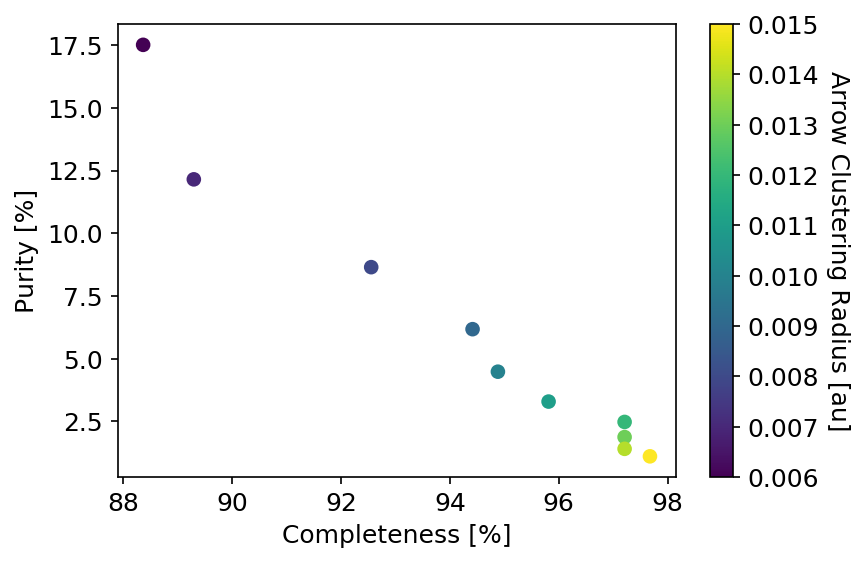

In [44]:
# plot ROC curve
plt.figure(dpi=150)
plt.scatter(roc[:,1],roc[:,2],c=roc[:,0])
plt.xlabel('Completeness [%]')
plt.ylabel('Purity [%]')
cbar = plt.colorbar()
cbar.set_label('Arrow Clustering Radius [au]', rotation=270, labelpad=15)
plt.show()

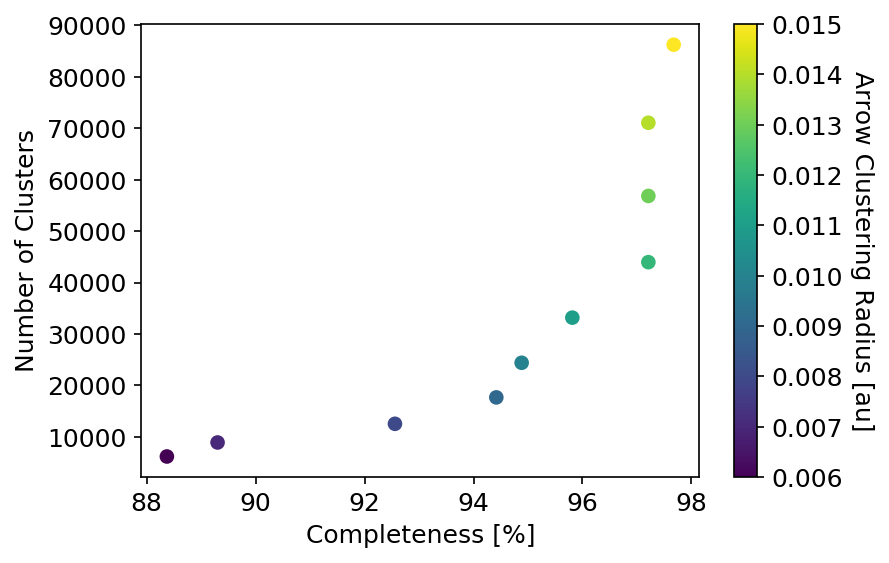

In [45]:
# Number of clusters vs completeness
plt.figure(dpi=150)
plt.scatter(roc[:,1],roc[:,3],c=roc[:,0])
plt.xlabel('Completeness [%]')
plt.ylabel('Number of Clusters')
cbar = plt.colorbar()
cbar.set_label('Arrow Clustering Radius [au]', rotation=270, labelpad=15)
plt.show()

## Rerun HelioLinC3D for different clustering parameters with mean state filtering

In [121]:

def heliolinc_roc(cr_arrow_range=np.arange(0.006,0.016,0.001),cr_obs=0.06,
                  ct_max=1.5/24, ct_min=25/86400, min_samples=3,
                  rall=np.arange(1.8,3.3,0.1),drdtall=np.append(np.arange(-0.01,0.0151,0.002),0),
                  n_cores=10, mean_state_filter_variance_limit=5e-8):
    """ Generate ROC data for HelioLinC3D. 
    
    Parameters:
    -----------
    cr_arrow_range    ... numpy array, Clustering radii for propagated arrows [au]
    cr_obs            ... float, Clustering radius for heliocentric positions projected from observations [au]
    ct_max            ... float, Maximum temporal separation for tracklet observations (days)
    min_samples       ... integer, Minimum number of arrows to be clustered ('DBSCAN only')
    rall              ... numpy array, Range of heliocentric distances searched by HelioLinC [au]
    rrdot             ... numpy array, Range of heliocentric radial velocities searched by HelioLinC [au/day]
    n_cores           ... integer, Number of cores available
    mean_state_filter_variance_limit ... float, Variance limit for mean state filtering 
                          of clusters (positions) [au^2]
                          
    Returns:
    --------
    
    """
    
    results=[]
    
    for cr_arrows in cr_arrow_range:


        # Iterator for joblib based paralellization
        rrdot=np.array(np.meshgrid(rall,drdtall)).T.reshape(-1,2)

        # How many configuraitons do we have to run in total?
        print("Configurations to run:" len(rrdot)*len(cr_arrow_range))


        n_cores=10

        with tqdm_joblib(tqdm(desc="HelioLinC2", total=len(rrdot))) as progress_bar:
            clusters_df=Parallel(n_jobs=n_cores)(delayed(hl.heliolinc2)
                                              (dfobs, r, drdt, cr_obs, cr_arrows, ct_min, ct_max, min_samples=min_samples,
                                               clustering_algorithm='dbscan', light_time=False, 
                                               verbose=False, n_jobs=1) 
                                               for r, drdt in rrdot ) 

        clustered_observations = (pd.concat(clusters_df)).reset_index(drop=True)  
        clustered_observations['clusterId']=clustered_observations.index

        dedupe=hl.deduplicateClusters(clustered_observations.sort_values(by=['var_pos','var_vel']) ).reset_index(drop=True)
        #filtering
        cog2=dedupe[dedupe['var_pos']<variance_limit].reset_index(drop=True)  
        cog2['cluster_Id']=cog2.index

        dfdifi=hl.linkages2difi(cog2,clusterId_name='cluster_Id',observationId_name='obsId',output='pandas')
        dfobs_difi=dfobs.merge(dfin_sel,left_on='obsName',right_on='obsName')
        dfobs_difi['obsId']=dfobs_difi['obsId'].astype(str)

        (all_truths, findable_observations, summary, 
               all_linkages_heliolinc, all_truths_heliolinc, summary_heliolinc,
               findable_objects, missed_objects) = hl.runDifi(dfobs_difi, cog2, 
                                                              obsIdName='obsId', linkageIdName='cluster_Id',
                                                              objIdName='ObjID', nightName='night', timeName='time',
                                                              findability='tracklet', linkage_min_obs=2, 
                                                              max_obs_separation=1.5/24, 
                                                              min_linkage_nights=3, 
                                                              metric="nightly_linkages")

        results.append([cr_arrows,all_truths, findable_observations, summary, 
               all_linkages_heliolinc, all_truths_heliolinc, summary_heliolinc,
               findable_objects, missed_objects])

HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2: 100%|██████████| 390/390 [03:26<00:00,  1.88it/s]


## Plot the ROC curve after mean state filtering 

In [126]:
roc_f=[]

for r in results_filtered:
    roc_f.append([r[0],r[6].completeness[0],r[6].pure_linkages/r[6].linkages*100,len(r[4].cluster_Id)])

roc_f=np.array(roc_f)

/epyc/projects/pytrax_play/envs/pytrax_s/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


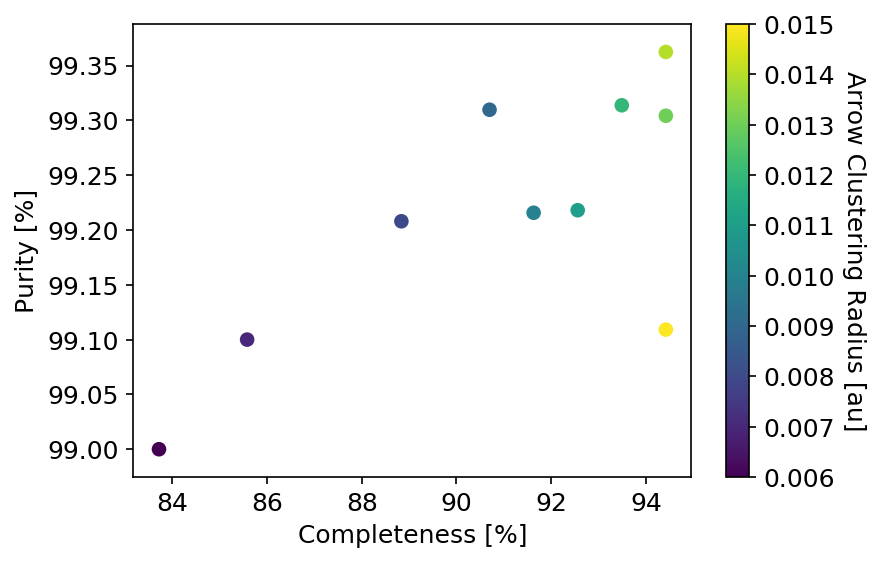

In [127]:
plt.figure(dpi=150)
plt.scatter(roc_f[:,1],roc_f[:,2],c=roc_f[:,0])
plt.xlabel('Completeness [%]')
plt.ylabel('Purity [%]')
cbar = plt.colorbar()
cbar.set_label('Arrow Clustering Radius [au]', rotation=270, labelpad=15)
plt.show()

## The above results are most promising as they show that HelioLinC3D achieves LSST requirements for completeness at a very high purity.

## Create a summary plot.

In [141]:
cr_arrow_range=np.arange(0.002,0.03,0.002)

results_filtered2=[]
variance_limit=5e-8

for cr_arrows in cr_arrow_range:
    # Clustering radius for heliocentric positions projected from observations [au]
    cr_obs=0.06
    # Clustering radius for propagated arrows [au]
    #cr_arrows=0.012
    # max temporal separation for tracklet observations (days)
    ct_max=1.5/24
    # min temporal separation for tracklet observations, e.g. exposure time (days)
    ct_min=25/86400 
    # Minimum number of arrows to be clustered ('DBSCAN only')
    min_samples=3


    # define range of heliocentric distances
    rall=np.arange(1.8,3.3,0.1)

    # define range of heliocentric radial velocities
    drdtall=np.arange(-0.01,0.0152,0.002)
    np.append(drdtall,0.0)

    # Iterator for joblib based paralellization
    rrdot=np.array(np.meshgrid(rall,drdtall)).T.reshape(-1,2)

    # How many configuraitons do we have to run?
    print(len(rrdot))


    n_cores=10

    with tqdm_joblib(tqdm(desc="HelioLinC2", total=len(rrdot))) as progress_bar:
        clusters_df=Parallel(n_jobs=n_cores)(delayed(hl.heliolinc2)
                                          (dfobs, r, drdt, cr_obs, cr_arrows, ct_min, ct_max, min_samples=min_samples,
                                           clustering_algorithm='dbscan', light_time=False, 
                                           verbose=False, n_jobs=1) 
                                           for r, drdt in rrdot ) 

    clustered_observations = (pd.concat(clusters_df)).reset_index(drop=True)  
    clustered_observations['clusterId']=clustered_observations.index

    number_of_clusters=len(clustered_observations.index)
    
    dedupe=hl.deduplicateClusters(clustered_observations.sort_values(by=['var_pos','var_vel']) ).reset_index(drop=True)
    #filtering
    number_of_deduplicated_clusters=len(dedupe.index)
        
    cog2=dedupe[dedupe['var_pos']<variance_limit].reset_index(drop=True)  
    cog2['cluster_Id']=cog2.index

    number_of_filtered_clusters=len(cog2.index)
    
    dfdifi=hl.linkages2difi(cog2,clusterId_name='cluster_Id',observationId_name='obsId',output='pandas')
    dfobs_difi=dfobs.merge(dfin_sel,left_on='obsName',right_on='obsName')
    dfobs_difi['obsId']=dfobs_difi['obsId'].astype(str)

    (all_truths, findable_observations, summary, 
           all_linkages_heliolinc, all_truths_heliolinc, summary_heliolinc,
           findable_objects, missed_objects) = hl.runDifi(dfobs_difi, cog2, 
                                                          obsIdName='obsId', linkageIdName='cluster_Id',
                                                          objIdName='ObjID', nightName='night', timeName='time',
                                                          findability='tracklet', linkage_min_obs=2, 
                                                          max_obs_separation=1.5/24, 
                                                          min_linkage_nights=3, 
                                                          metric="nightly_linkages")
    print(cr_arrows,summary_heliolinc.completeness)
    results_filtered2.append([cr_arrows,all_truths, findable_observations, summary, 
           all_linkages_heliolinc, all_truths_heliolinc, summary_heliolinc,
           findable_objects, missed_objects,number_of_clusters,number_of_deduplicated_clusters,
                             number_of_filtered_clusters])

HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.002 0    61.395349
Name: completeness, dtype: float64
195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.004 0    77.209302
Name: completeness, dtype: float64
195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.006 0    83.72093
Name: completeness, dtype: float64
195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.008 0    88.837209
Name: completeness, dtype: float64
195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.01 0    91.627907
Name: completeness, dtype: float64
195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.012 0    93.488372
Name: completeness, dtype: float64
195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.014 0    94.418605
Name: completeness, dtype: float64
195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.016 0    94.883721
Name: completeness, dtype: float64
195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.018000000000000002 0    95.348837
Name: completeness, dtype: float64
195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.020000000000000004 0    95.348837
Name: completeness, dtype: float64
195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.022 0    96.744186
Name: completeness, dtype: float64
195


HelioLinC2:   5%|▍         | 9/195 [00:12<06:20,  2.05s/it]/epyc/projects/pytrax_play/envs/pytrax_s/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.024 0    96.744186
Name: completeness, dtype: float64
195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.026000000000000002 0    96.27907
Name: completeness, dtype: float64
195


HelioLinC2:   4%|▎         | 7/195 [00:11<25:40,  8.19s/it]/epyc/projects/pytrax_play/envs/pytrax_s/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
HelioLinC2: 100%|██████████| 195/195 [01:52<00:00,  1.74it/s]


0.028000000000000004 0    96.27907
Name: completeness, dtype: float64


In [203]:
roc_f2=[]

for r in results_filtered2:
    roc_f2.append([r[0],r[6].completeness[0],
                   r[6].pure_linkages/r[6].linkages*100,len(r[4].cluster_Id),
                   r[9],r[10],r[11],r[6].findable_found+r[6].findable_found ])

roc_f2=np.array(roc_f2)

/epyc/projects/pytrax_play/envs/pytrax_s/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


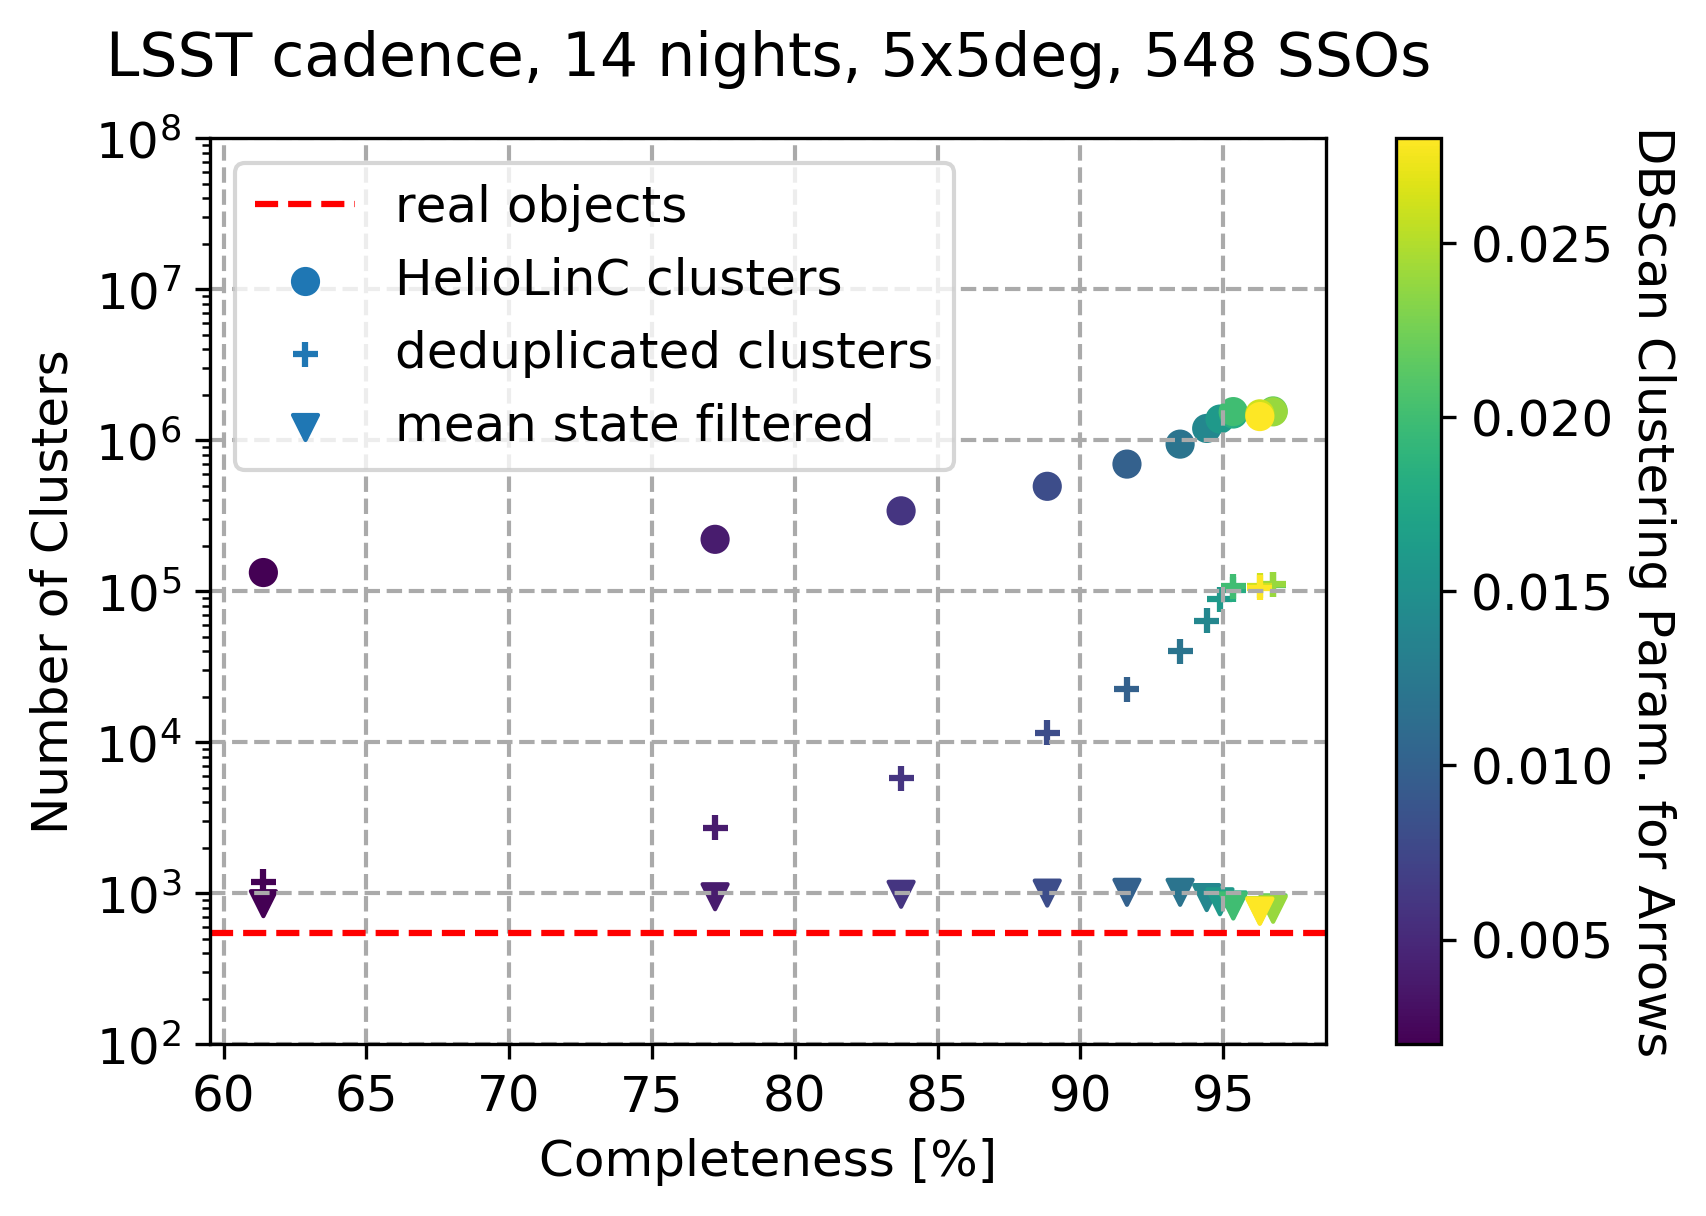

In [227]:
plt.figure(dpi=300)
plt.scatter(roc_f2[:,1],roc_f2[:,4],c=roc_f2[:,0],label='HelioLinC clusters')
plt.scatter(roc_f2[:,1],roc_f2[:,5],c=roc_f2[:,0],label='deduplicated clusters',marker='+')
plt.scatter(roc_f2[:,1],roc_f2[:,3],c=roc_f2[:,0],label='mean state filtered',marker='v')
plt.axhline(y=results_filtered2[0][6].num_members.values, color='r', linestyle='--',label='real objects')
plt.ylim(100,1e8)
plt.xlabel('Completeness [%]')
plt.ylabel('Number of Clusters')
plt.yscale('log')
cbar = plt.colorbar()
cbar.set_label('DBScan Clustering Param. for Arrows', rotation=270, labelpad=15)
plt.xticks(np.arange(60,100,5)) 
plt.grid(color='#AAAAAA', linestyle='--', linewidth=1)
plt.legend(loc='upper left')
plt.title("LSST cadence, 14 nights, 5x5deg, 548 SSOs",pad=15)
plt.show()

# Conclusions

* HelioLinC3D performs at least as good as classical MOPS in terms of finding objects. Currently, it performs best for objects with fewer (~4) observations. 
* Mean state filtering with conservative on sky O-C RMS values allows us to select clusters that are essentially completely free from noise.

